In [11]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
# pd.set_option("display.max_columns", 50)

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

In [767]:
# Pickling Call Volume 2018 df
redo_pickle = False

if redo_pickle == True:
    with open('hourly_call_volume_medical_2018.pickle','wb') as f:
        pickle.dump(hourly_call_volume_medical_2018,f)
        
if redo_pickle == False:
    with open('hourly_call_volume_medical_2018.pickle','rb') as f:
        hourly_call_volume_medical_2018 = pickle.load(f)

In [768]:
# hourly_intervals_2018 = pd.date_range(start='1/1/2018 00:00:00', end='12/31/2018 23:00:00', freq='H')

In [769]:
hourly_call_volume_medical_2018 = hourly_call_volume_medical_2018.asfreq('H',fill_value=0)

In [3]:
# Pickling Unavailable Units 2018 df
redo_pickle = False

if redo_pickle == True:
    with open('unavailable_units_15_min_int_counts_2018_df.pickle','wb') as f:
        pickle.dump(unavailable_units_15_min_int_counts_2018_df,f)
        
if redo_pickle == False:
    with open('unavailable_units_15_min_int_counts_2018_df.pickle','rb') as f:
        unavailable_units_15_min_int_counts_2018_df = pickle.load(f)

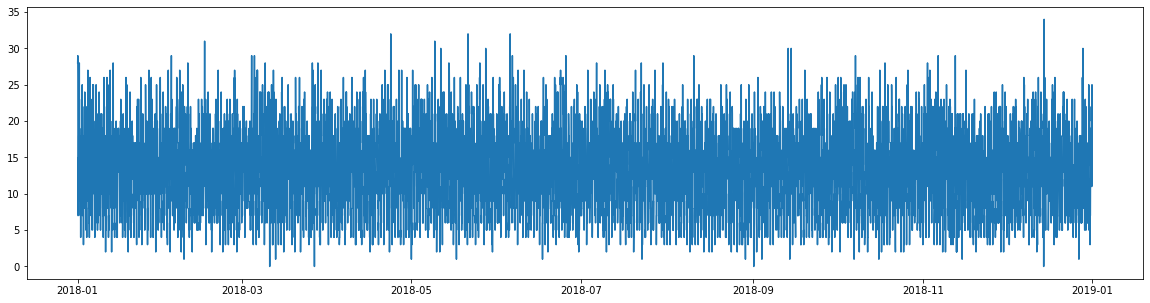

In [369]:
plt.figure(figsize=(20,5))
sns.lineplot(data=hourly_call_volume_medical_2018)

### Hourly Lag Autocorrelation

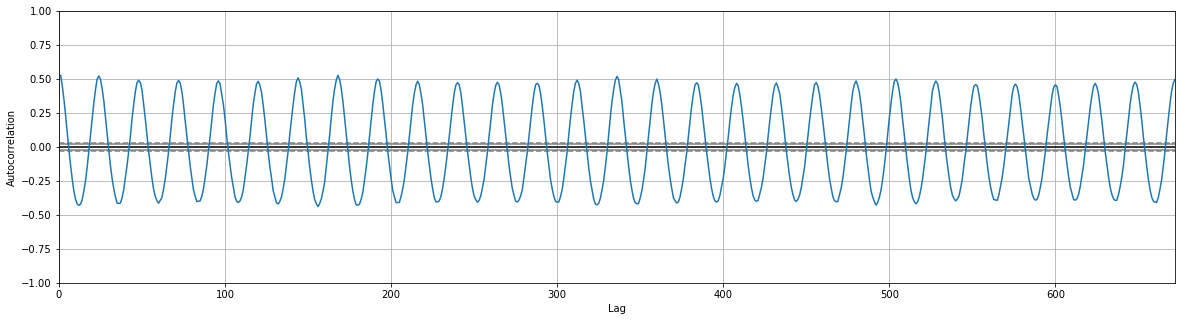

In [1034]:
plt.figure(figsize=(20,5))
autocorrelation_plot(hourly_call_volume_medical_2018)
plt.xlim(0,336*2); # past two weeks 

In [336]:
# calculating lags
lag_list = []
for i in range(1,24):
    lag_list.append(hourly_call_volume_medical_2018.autocorr(lag=i))

In [337]:
lag_list

[0.5262513736616988,
 0.45016381990171184,
 0.3505001953018775,
 0.232619371304781,
 0.10162022719077426,
 -0.022905010165297647,
 -0.13425614166342548,
 -0.23799657527279378,
 -0.32778160228990666,
 -0.3860697722251022,
 -0.42151303773946125,
 -0.43074665377494026,
 -0.42222492694079533,
 -0.3895613145072722,
 -0.32585804718119454,
 -0.24926534174615353,
 -0.1484614560562621,
 -0.029017075173006165,
 0.09447528032120033,
 0.21418074653287175,
 0.3242739696945577,
 0.4214218184211689,
 0.5016277631297348]

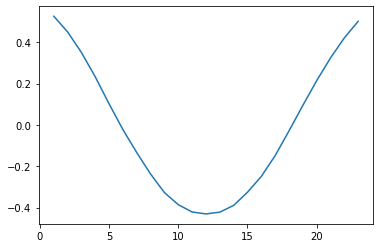

In [310]:
sns.lineplot(range(1,24),lag_list)

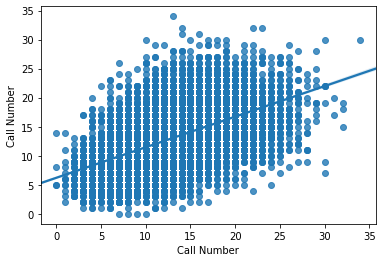

In [343]:
# Plotting lag of 1 correlation scatter plot
sns.regplot(hourly_call_volume_medical_2018,hourly_call_volume_medical_2018.shift(periods=1, fill_value=np.nan))

### Hourly Decomposition

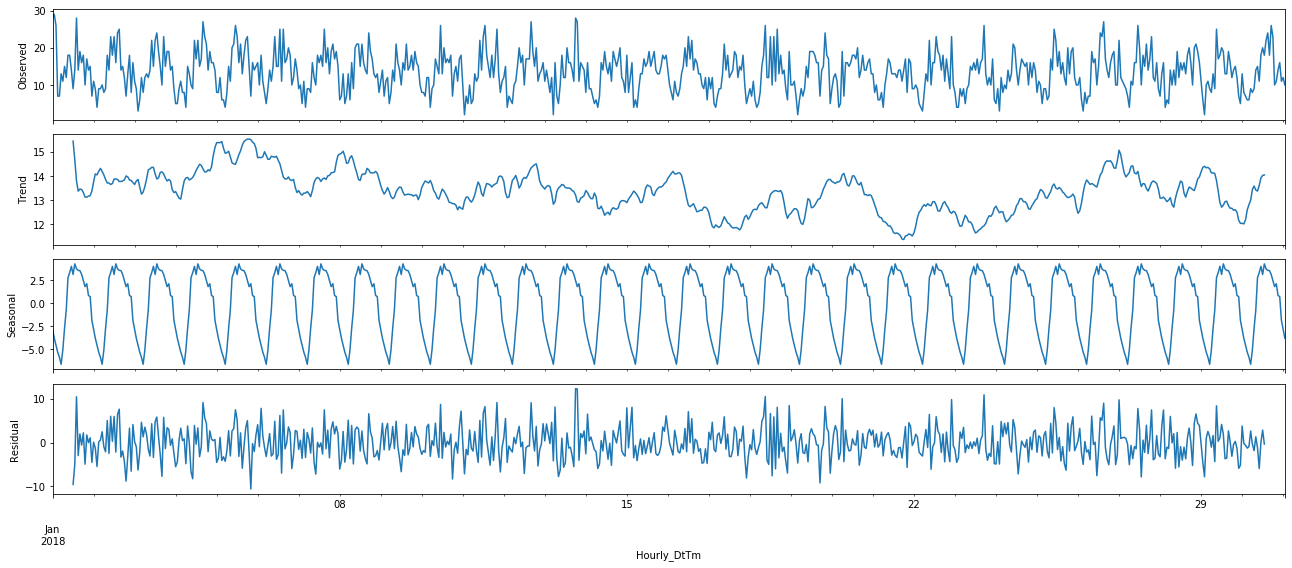

In [395]:
decomposition = seasonal_decompose(hourly_call_volume_medical_2018[:722], model='additive')

decomposition.plot();

### Daily Lag Autocorrelation

In [519]:
# resample all store data to average daily sales
daily_average_call_volume_medical_2018 = hourly_call_volume_medical_2018.resample('D').mean()

daily_average_call_volume_medical_2018.head(10)

Hourly_DtTm
2018-01-01    15.791667
2018-01-02    13.875000
2018-01-03    14.208333
2018-01-04    14.166667
2018-01-05    14.500000
2018-01-06    14.791667
2018-01-07    13.958333
2018-01-08    13.708333
2018-01-09    13.583333
2018-01-10    13.416667
Freq: D, Name: Call Number, dtype: float64

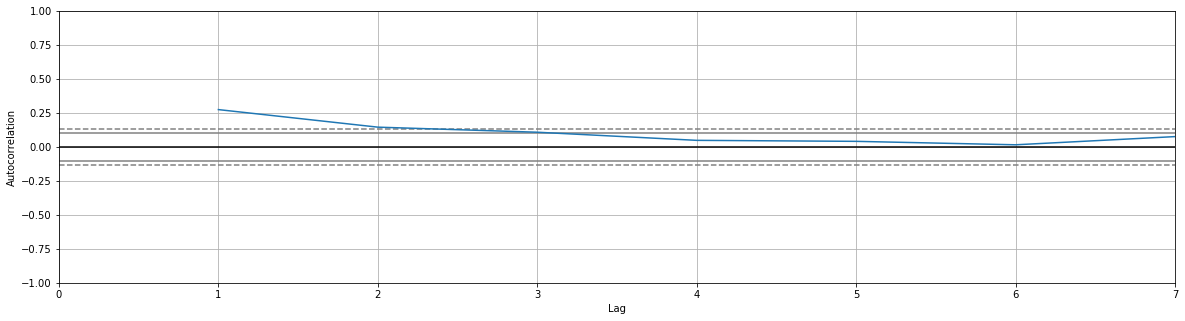

In [318]:
plt.figure(figsize=(20,5))
autocorrelation_plot(daily_average_call_volume_medical_2018)
plt.xlim(0,7); # past two weeks 

In [324]:
# calculating lags
lag_list = []
for i in range(1,14):
    lag_list.append(daily_average_call_volume_medical_2018.autocorr(lag=i))

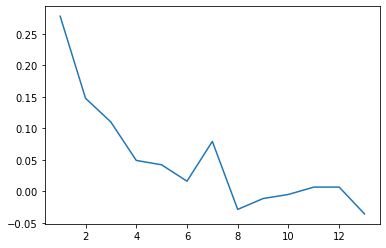

In [325]:
sns.lineplot(range(1,14),lag_list)

### Daily Decomposition

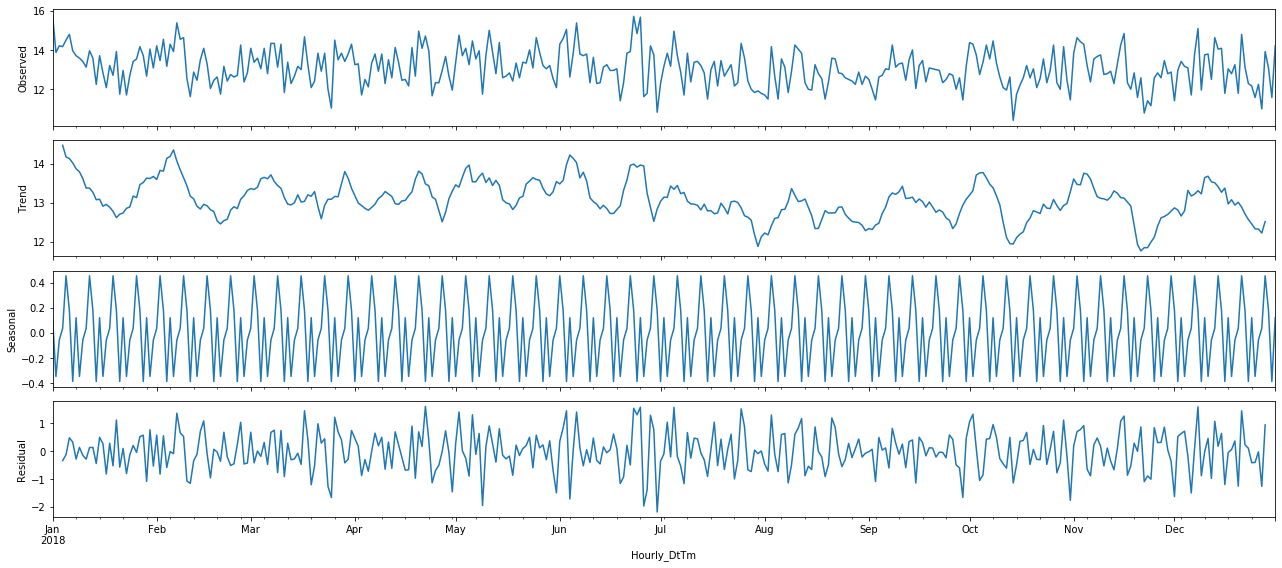

In [536]:
# All 2018
decomposition = seasonal_decompose(daily_average_call_volume_medical_2018, model='additive')
decomposition.plot();

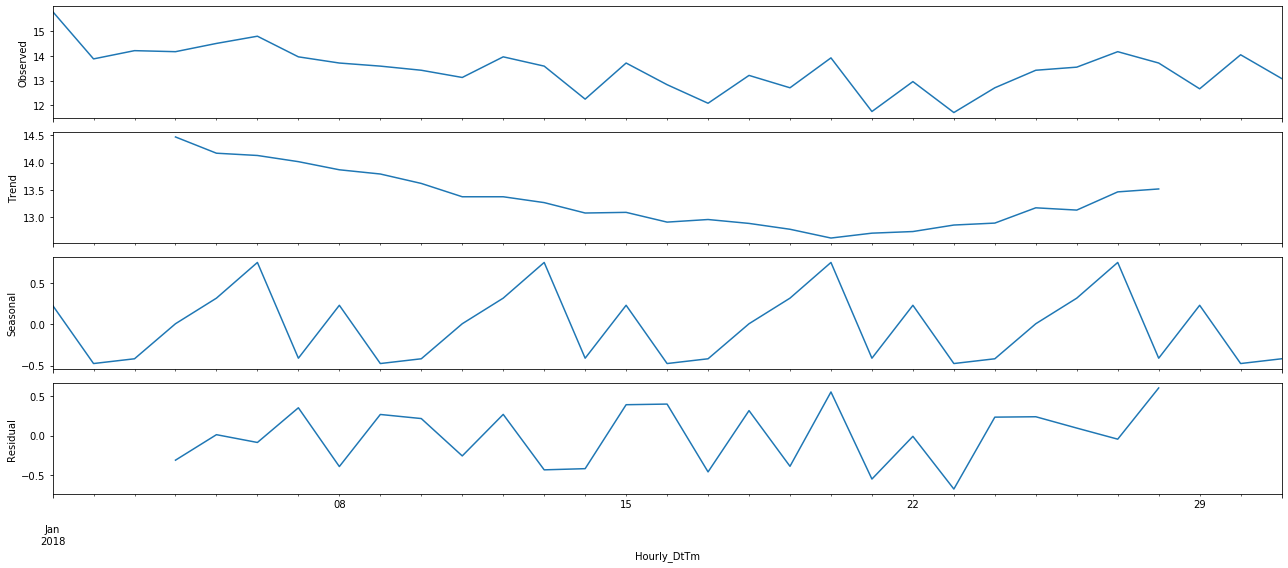

In [540]:
# January 2018
decomposition = seasonal_decompose(daily_average_call_volume_medical_2018[:31], model='additive')
decomposition.plot();

### Hourly Violin Plot

In [520]:
violin_hourly_call_volume_medical_2018 = hourly_call_volume_medical_2018.copy()

In [521]:
violin_hourly_call_volume_medical_2018.index = hourly_call_volume_medical_2018.index.hour

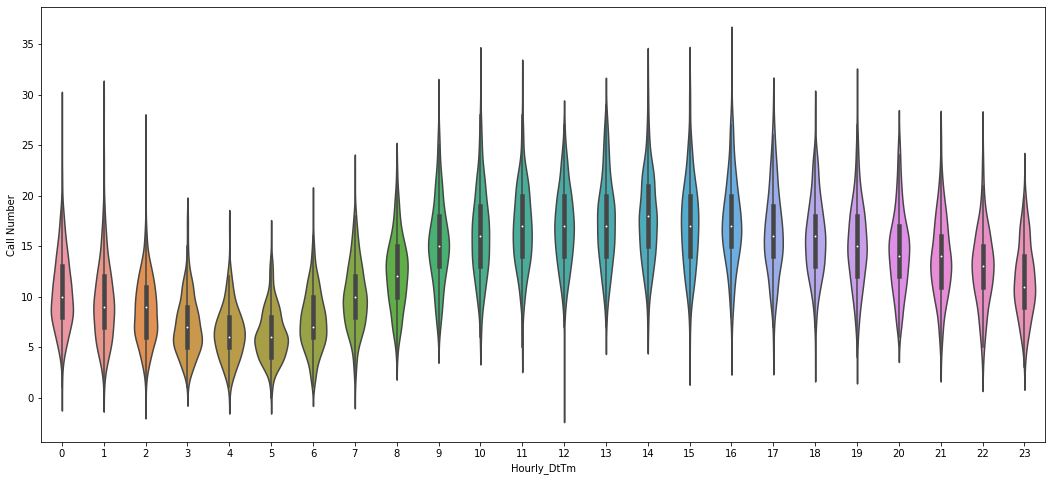

In [522]:
sns.violinplot(x=violin_hourly_call_volume_medical_2018.index, y=violin_hourly_call_volume_medical_2018)

### Daily Violin Plot

In [523]:
violin_daily_average_call_volume_medical_2018 = daily_average_call_volume_medical_2018.copy()

In [524]:
violin_daily_average_call_volume_medical_2018.index = daily_average_call_volume_medical_2018.index.dayofweek

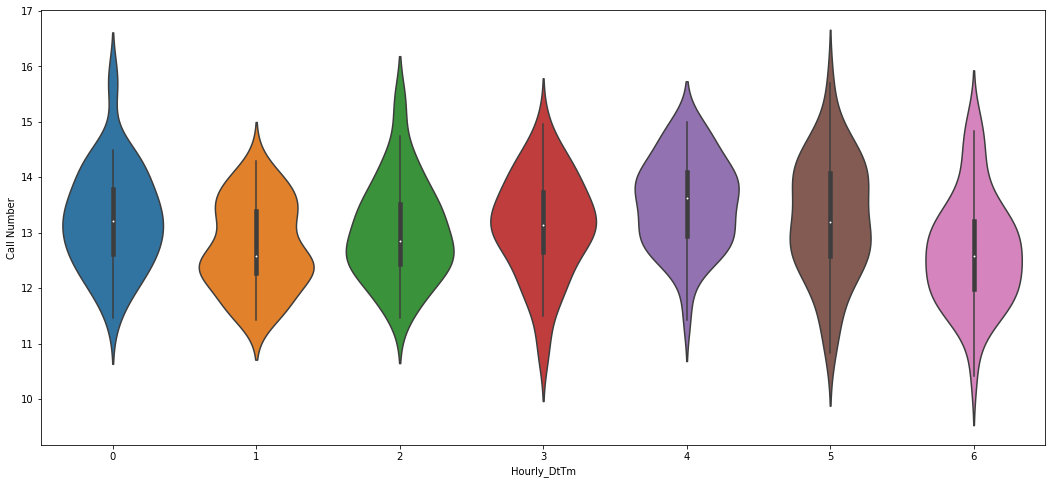

In [525]:
sns.violinplot(x=violin_daily_average_call_volume_medical_2018.index, y=violin_daily_average_call_volume_medical_2018)

### Checking for stationarity in data

In [534]:
# Since 
print(hourly_call_volume_medical_2018.std())
print(hourly_call_volume_medical_2018.diff().std())
print(hourly_call_volume_medical_2018.diff().diff().std())

5.419892379592953
5.27467711134557
8.888856031546311


In [715]:
# Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=72).mean()
    rolstd = timeseries.rolling(window=72).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test Statistic         -1.357363e+01
p-value                 2.190759e-25
Lags Used               3.400000e+01
Observations Used       8.725000e+03
Critical Value (1%)    -3.431100e+00
Critical Value (5%)    -2.861871e+00
Critical Value (10%)   -2.566946e+00
dtype: float64


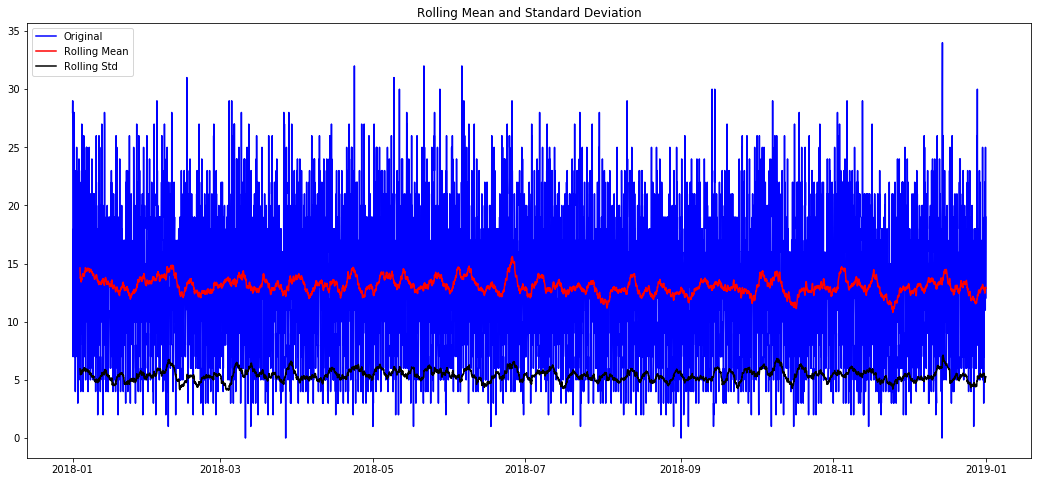

In [716]:
# run DFT on monthly
dftest(hourly_call_volume_medical_2018)
# p-value allows us to reject a unit root: data is stationary

In [978]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [976]:
# plt.subplot(121)
# sns.lineplot(x=[1,2,3],y=[3,4,5])
# plt.subplot(122)
# sns.lineplot(x=[2,3,4],y=[4,5,6])
# sns.despine()


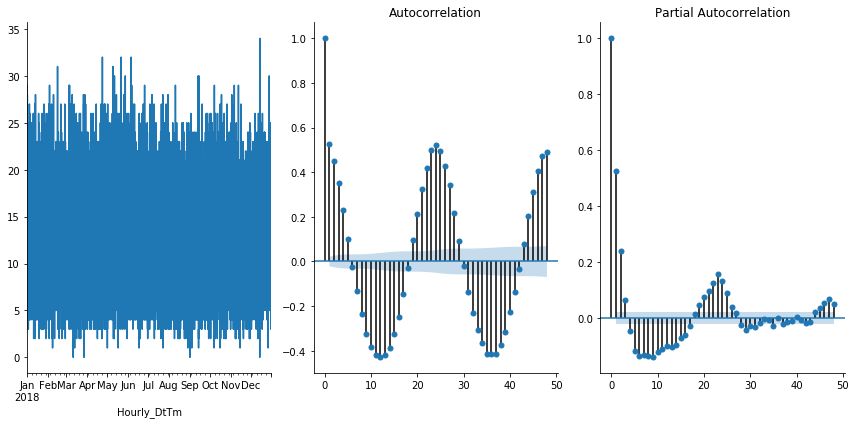

In [979]:
# helper plot for monthly temps
plots(hourly_call_volume_medical_2018, lags=48);
# open Duke guide for visual
# we note a 12-period cycle (yearly) with suspension bridge design, so must use SARIMA < - jonathans words

### ARIMA

                              ARMA Model Results                              
Dep. Variable:            Call Number   No. Observations:                 8760
Model:                     ARMA(1, 0)   Log Likelihood              -25814.353
Method:                       css-mle   S.D. of innovations              4.608
Date:                Mon, 10 Jun 2019   AIC                          51634.707
Time:                        11:22:05   BIC                          51655.940
Sample:                    01-01-2018   HQIC                         51641.942
                         - 12-31-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                13.0935      0.104    125.942      0.000      12.890      13.297
ar.L1.Call Number     0.5265      0.009     57.923      0.000       0.509       0.544
                        

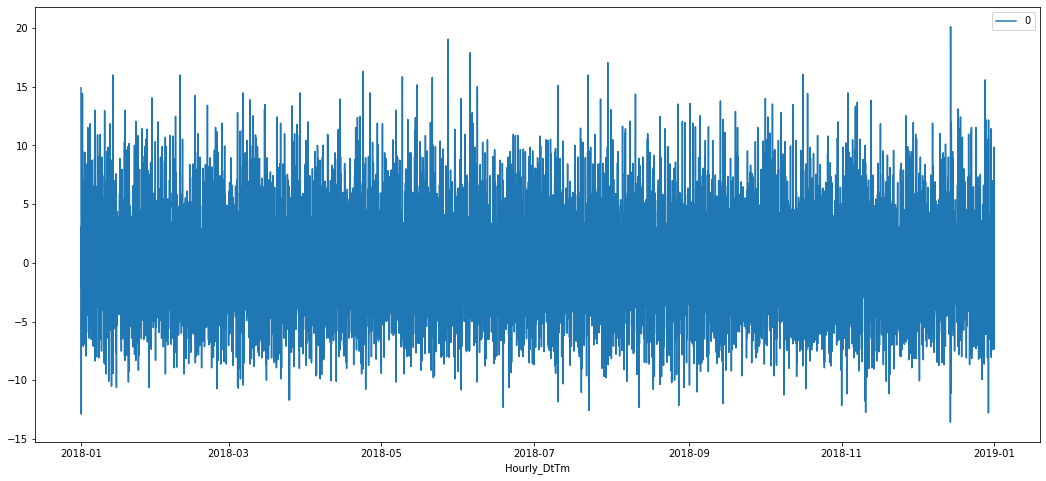

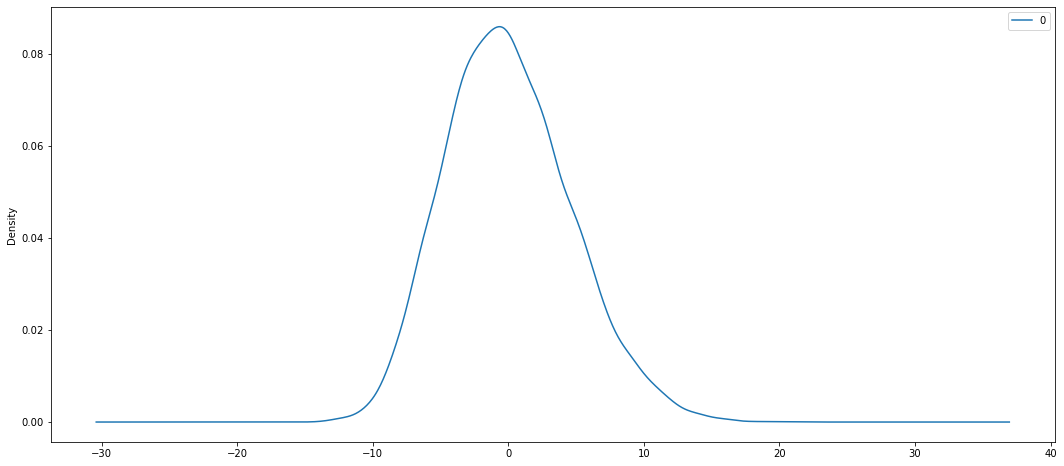

                 0
count  8760.000000
mean     -0.000897
std       4.609454
min     -13.570736
25%      -3.359099
50%      -0.306190
75%       2.955719
max      20.114446


In [782]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(hourly_call_volume_medical_2018, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plotting residual errors
residuals = pd.DataFrame(model_fit.resid)
# plt.figure(figsize=(20,5))
sns.lineplot(data=residuals)
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [879]:
# ARIMA
X = hourly_call_volume_medical_2018.values[:722]
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

predicted=13.824698, expected=14.000000
predicted=13.825066, expected=16.000000
predicted=14.725479, expected=17.000000
predicted=15.179452, expected=13.000000
predicted=13.381992, expected=13.000000
predicted=13.381188, expected=8.000000
predicted=11.129612, expected=10.000000
predicted=12.021737, expected=6.000000
predicted=10.203377, expected=6.000000
predicted=10.177380, expected=8.000000
predicted=11.071068, expected=4.000000
predicted=9.215676, expected=10.000000
predicted=11.957148, expected=13.000000
predicted=13.326833, expected=17.000000
predicted=15.156009, expected=16.000000
predicted=14.702818, expected=13.000000
predicted=13.332694, expected=13.000000
predicted=13.332014, expected=13.000000
predicted=13.331335, expected=12.000000
predicted=12.873216, expected=14.000000
predicted=13.786241, expected=14.000000
predicted=13.786672, expected=11.000000
predicted=12.415437, expected=14.000000
predicted=13.784096, expected=17.000000
predicted=15.155634, expected=8.000000
predict

predicted=16.004057, expected=13.000000
predicted=13.259595, expected=13.000000
predicted=13.259214, expected=19.000000
predicted=16.002201, expected=16.000000
predicted=14.634892, expected=12.000000
predicted=12.808504, expected=14.000000
predicted=13.721028, expected=15.000000
predicted=14.178266, expected=12.000000
predicted=12.809252, expected=7.000000
predicted=10.522118, expected=5.000000
predicted=9.587649, expected=13.000000
predicted=13.252723, expected=8.000000
predicted=10.964666, expected=7.000000
predicted=10.495914, expected=6.000000
predicted=10.021518, expected=6.000000
predicted=10.004690, expected=9.000000
predicted=11.382063, expected=8.000000
predicted=10.912730, expected=9.000000
predicted=11.369028, expected=14.000000
predicted=13.681307, expected=15.000000
predicted=14.144450, expected=11.000000
predicted=12.295615, expected=18.000000
predicted=15.527483, expected=20.000000
predicted=16.461270, expected=18.000000
predicted=15.543077, expected=22.000000
predicted=

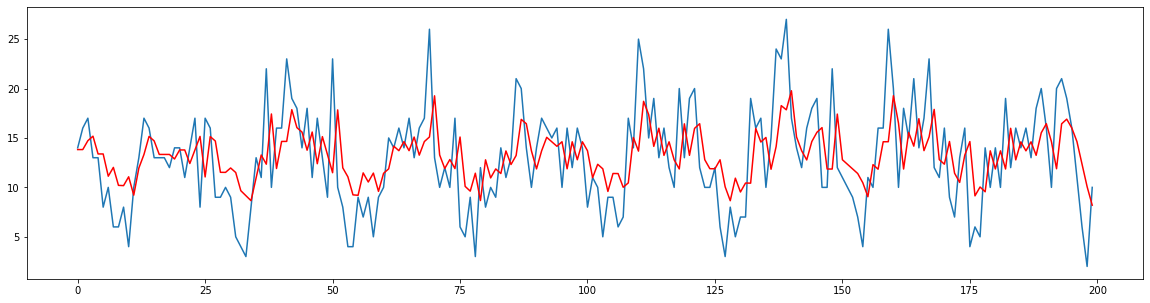

In [880]:
# plot ARIMA
plt.figure(figsize=(20,5))
plt.plot(test[:200])
plt.plot(predictions[:200], color='red')
plt.show()

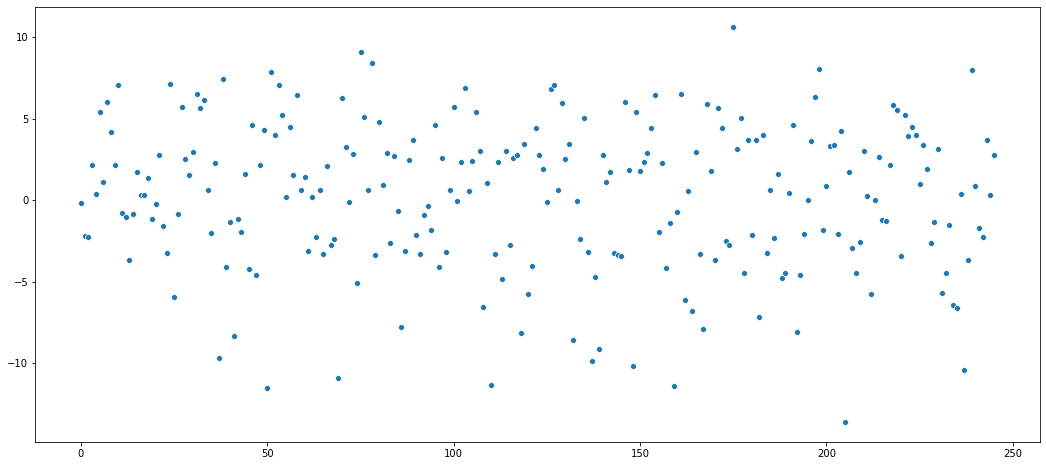

In [813]:
# Checking for residuals (look evenly distributed)
# plt.figure()
sns.scatterplot(x=(range(len(test))),y=[float(x) for x in predictions]-test)

In [981]:
# SARIMA
# Relabeling time series data
X = hourly_call_volume_medical_2018.values #722

# Creating Train-Test split
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

# Accumulator variable assignments
history = [x for x in train]
predictions = list()

# Loop for predicting the next value using previous data
for t in range(len(test)):
    # Instantiating model
    model = SARIMAX(history,order=(3,1,1),
                    seasonal_order=(1,0,1,24),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    # Training Model
    model_fit = model.fit()
    
    # Predicting one step into future and adding to prediction list
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    
    # Appending actual test observation to train data
    # so that on the next iteration, the model will train 
    # on all previous data and the next time step
    obs = test[t]
    history.append(obs)
    
    # Displaying predicted vs actual values
    print('predicted=%f, expected=%f' % (yhat, obs))

# Calculating and printing MSE for all test predictions    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.697953, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.624275, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.254124, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.770780, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.798878, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.124171, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.508166, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.970228, expected=3.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.593505, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.900253, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.225974, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.683343, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.603441, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.429448, expected=25.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.141138, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.796593, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.118026, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.996279, expected=22.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.484768, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.417509, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.543280, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.612879, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.999744, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.305459, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.278749, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.457735, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.528129, expected=6.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.464357, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.801318, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.520509, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.472454, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.854696, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.754370, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.531355, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.365734, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.528490, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.197258, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.069861, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.914799, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.063156, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.664744, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.947587, expected=21.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.326533, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.318072, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.661361, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.715625, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.440891, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.514073, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.589685, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.218814, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.123283, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.251186, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.750193, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.645351, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.254644, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.447799, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.165043, expected=0.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.917308, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.764681, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.555484, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.314018, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.478670, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.570544, expected=24.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.813025, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.506860, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.001086, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.519763, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.794715, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.778590, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.451325, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.173255, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.897422, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.466250, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.397297, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.363669, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.114421, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.339229, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.321756, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.136660, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.363591, expected=6.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.964713, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.161688, expected=2.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.172270, expected=3.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.921215, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.177885, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.695040, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.950847, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.968569, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.007141, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.433173, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.732602, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.787909, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.820335, expected=26.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.601786, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.392032, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.703615, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.994006, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.154349, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.968142, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.357874, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.035293, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.727304, expected=10.000000
predicted=6.515500, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.088319, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.726564, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.917200, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.330794, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.093603, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.466930, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.240824, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.869964, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.030953, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.499814, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.178526, expected=22.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.909692, expected=20.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.471848, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.741923, expected=21.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.801597, expected=11.000000
predicted=14.935920, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.759767, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.876333, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.110279, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.013787, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.684228, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.542738, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.429497, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.488832, expected=1.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.505298, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.310221, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.842898, expected=6.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.244238, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.813601, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.608824, expected=20.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.046102, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.555731, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.764564, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.729889, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.874665, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.858623, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.848685, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.021257, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.962906, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.942518, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.834622, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.217465, expected=22.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.086578, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.579962, expected=6.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.413468, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.905233, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.775211, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.745667, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.896668, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.580184, expected=6.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.923710, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.480331, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.712198, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.526684, expected=24.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.067099, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.466841, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.264767, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.714430, expected=21.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.254392, expected=21.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.484249, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.301933, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.642454, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.360118, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.602016, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.002530, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.635826, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.774071, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.922594, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.088290, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.165377, expected=12.000000
predicted=8.465969, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.846274, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.274839, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.391662, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.375790, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.677674, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.020387, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.964969, expected=21.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.109248, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.637764, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.879982, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.820849, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.124002, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.857449, expected=21.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.220114, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.762541, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.429163, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.391833, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.895303, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.108216, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.667646, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.847657, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.031824, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.826366, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.886054, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.584491, expected=5.000000
predicted=5.941642, expected=3.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.581533, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.772148, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.276979, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.530160, expected=20.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.268714, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.039724, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.472616, expected=21.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.585290, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.663654, expected=24.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.617904, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.977798, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.356915, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.141145, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.861092, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.770554, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.624682, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.565377, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.003125, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.220769, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.437443, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.335784, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.260183, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.065421, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.355548, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.059629, expected=3.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.060496, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.343395, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.704675, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.766059, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.460961, expected=20.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.506678, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.796150, expected=24.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.700582, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.391832, expected=22.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.685816, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.296014, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.466214, expected=21.000000
predicted=15.642828, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.706470, expected=22.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.547093, expected=10.000000
predicted=13.645888, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.343540, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.211104, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.866711, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.637561, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.199200, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.430492, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.924089, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.075451, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.662498, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.610623, expected=13.000000
predicted=12.044907, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.732725, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.934909, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.497018, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.737235, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.985609, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.597082, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.874218, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.486172, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.150236, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.638928, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.194703, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.701754, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.161619, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.150617, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.138070, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.519548, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.379829, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.995848, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.448621, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.591328, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.797994, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.306401, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.956207, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.399245, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.104693, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.612555, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.350917, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.307785, expected=24.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.175893, expected=22.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.661927, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.875959, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.272737, expected=22.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.984593, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.570033, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.156348, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.964303, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.641399, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.815419, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.942327, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.870114, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.009450, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.166853, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.697891, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.090953, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.587170, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.371699, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.050427, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.929691, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.257962, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.592060, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.326623, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.165653, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.363225, expected=20.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.951161, expected=20.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.025020, expected=22.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.651187, expected=22.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.990690, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.963430, expected=20.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.800259, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.314318, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.882913, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.777722, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.493666, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.201454, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.108369, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.667621, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.050237, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.009689, expected=6.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.740591, expected=5.000000
predicted=7.202705, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.583402, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.819203, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.900342, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.788449, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.773731, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.805777, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.308748, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.161591, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.873513, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.716132, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.042687, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.046517, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.077386, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.117484, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.412957, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.814698, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.061489, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.350376, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.650011, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.297959, expected=8.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.528993, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.248020, expected=9.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.082985, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.697036, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.881517, expected=6.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.752858, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.462343, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.566644, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.614663, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.780398, expected=20.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.766330, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.323219, expected=30.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=18.266295, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.766759, expected=16.000000
predicted=16.812150, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.293482, expected=20.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.461715, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.550078, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.888146, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.070743, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.297141, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.820122, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.711251, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.787992, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.021816, expected=6.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.169808, expected=1.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.686543, expected=3.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.899258, expected=2.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.238393, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.650612, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.015933, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.166752, expected=21.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.239792, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.088064, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.194635, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.534432, expected=23.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.621251, expected=22.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.806655, expected=30.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.808519, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.821292, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.857428, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.907070, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.690235, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.498034, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.410070, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.604198, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.392976, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=8.671152, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.091353, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.267574, expected=3.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.788867, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.965473, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.892180, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.964842, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.521514, expected=21.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.255348, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.775165, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.919180, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.225273, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.273821, expected=10.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.697887, expected=18.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.666707, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.996555, expected=6.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.812633, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.667389, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.290838, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.180430, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.524605, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=11.509269, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.715817, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.830003, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.185739, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.636715, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.577910, expected=7.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.244798, expected=5.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=7.331288, expected=4.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=9.595973, expected=14.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.026226, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=14.850313, expected=17.000000
predicted=16.189281, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.278513, expected=17.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.611515, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.067206, expected=22.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.600364, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.033825, expected=19.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17.364424, expected=21.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=16.404885, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.485132, expected=15.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=15.217940, expected=12.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.596648, expected=13.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.393740, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=12.721490, expected=11.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.968903, expected=16.000000


/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=10.352649, expected=7.000000


KeyboardInterrupt: 

In [ ]:
# Pickling best_sarima_model_fit
redo_pickle = False

if redo_pickle == True:
    with open('best_sarima_model_fit.pickle','wb') as f:
        pickle.dump(model_fit,f)
        
if redo_pickle == False:
    with open('best_sarima_model_fit.pickle','rb') as f:
        model_fit = pickle.load(f)

In [ ]:
# Pickling  best_sarima_model
redo_pickle = False

if redo_pickle == True:
    with open('best_sarima_model.pickle','wb') as f:
        pickle.dump(model,f)
        
if redo_pickle == False:
    with open('best_sarima_model.pickle','rb') as f:
        model = pickle.load(f)

In [3]:
# Pickling sarima_predictions
redo_pickle = False

if redo_pickle == True:
    with open('sarima_predictions.pickle','wb') as f:
        pickle.dump(predictions,f)
        
if redo_pickle == False:
    with open('sarima_predictions.pickle','rb') as f:
        predictions = pickle.load(f)

In [5]:
# Pickling sarima_test
redo_pickle = False

if redo_pickle == True:
    with open('sarima_test.pickle','wb') as f:
        pickle.dump(test[:436],f)
        
if redo_pickle == False:
    with open('sarima_test.pickle','rb') as f:
        test = pickle.load(f)

In [14]:
# Calculating and printing MSE for all test predictions    
error = mean_squared_error(test[:436], predictions)
print('Test RMSE: %.3f' % np.sqrt(error))

Test RMSE: 3.508


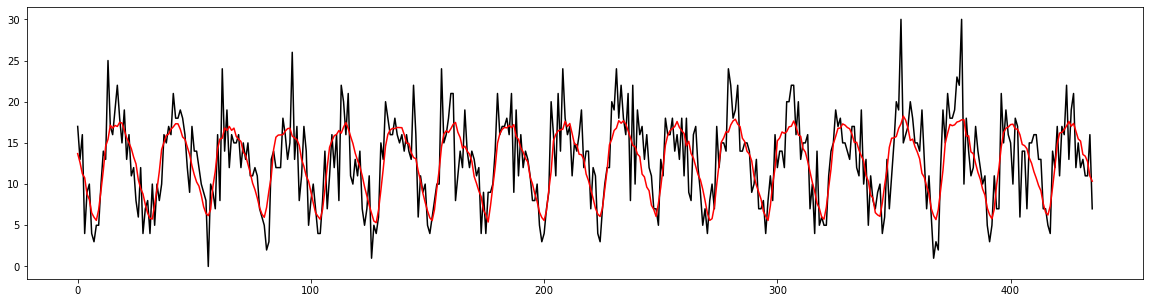

In [15]:
# plot SARIMA
plt.figure(figsize=(20,5))
plt.plot(test[:436], color='black')
plt.plot(predictions, color='red')
plt.show()

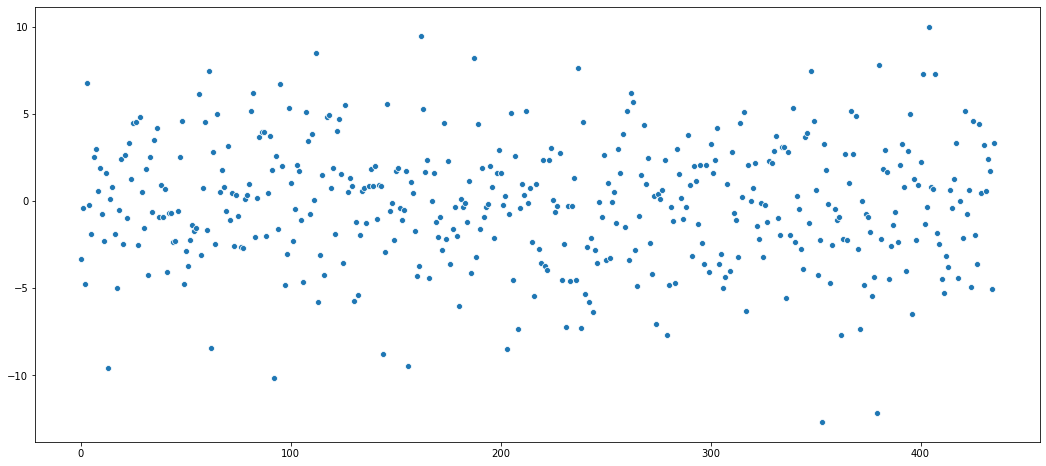

In [12]:
# Checking for residuals (look evenly distributed)
sns.scatterplot(x=(range(len(test[:436]))),y=[float(x) for x in predictions]-test[:436])

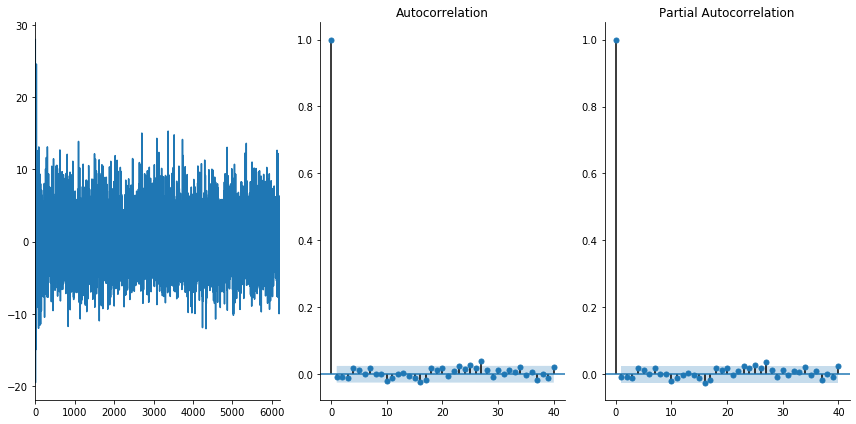

In [990]:
# plot resids
plots(pd.Series(model_fit.resid), lags=40);

In [1017]:
for x,y in zip(model_fit.param_terms,model_fit.params):
    print(x,y)

ar 0.06596343593967544
ma 0.051793942922233785
seasonal_ar 0.048370433272035454
seasonal_ma -0.9979784621223932
variance 0.99986898185224


In [807]:
X = hourly_call_volume_medical_2018.values[:722]
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
model = ARIMA(train, order=(1,0,0)).fit()
model.summary()

NameError: name 'SARIMA' is not defined

TypeError: predict() got an unexpected keyword argument 'n_periods'

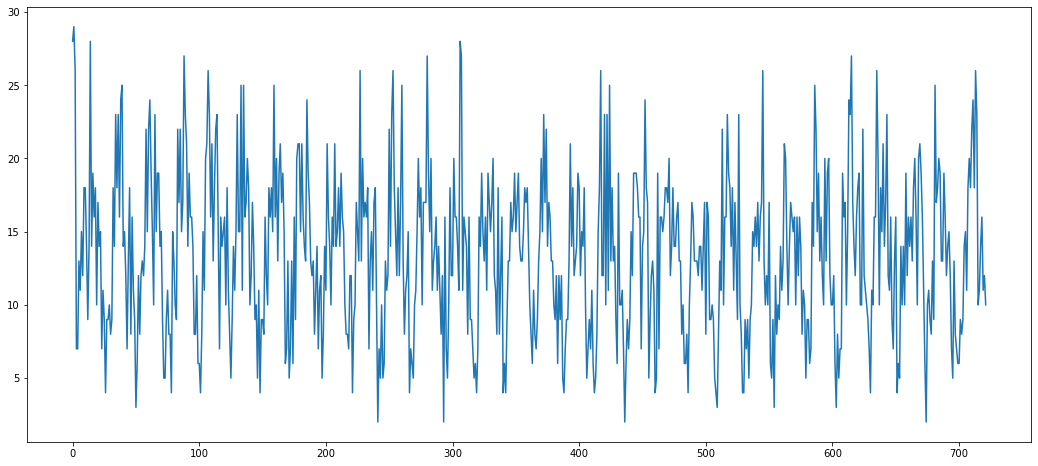

In [695]:
sns.lineplot(data=X)
sns.lineplot(x=range(426,723), y=model.predict(n_periods=len(range(426,723))))

In [664]:
792-730

62

In [665]:
750+30

780

In [666]:
476-50

426

In [690]:
# plot predictions
hourly_call_volume_medical_2018_df = pd.DataFrame(hourly_call_volume_medical_2018)
hourly_call_volume_medical_2018_df['forecast'] = model.predict(start=426, end=722, dynamic=48) 
hourly_call_volume_medical_2018_df[['Call Number', 'forecast']].plot();

ValueError: Length of values does not match length of index

ValueError: arrays must all be same length

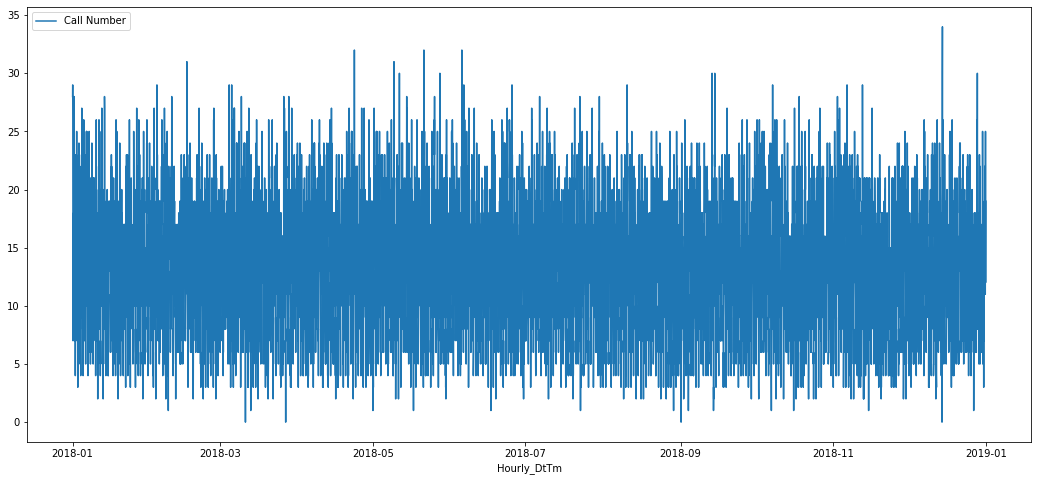

In [655]:
sns.lineplot(data=X)
sns.lineplot(x=hourly_call_volume_medical_2018.index,y=model.predict())

In [657]:
hourly_call_volume_medical_2018

Hourly_DtTm
2018-01-01 00:00:00    28
2018-01-01 01:00:00    29
2018-01-01 02:00:00    26
2018-01-01 03:00:00     7
2018-01-01 04:00:00     7
2018-01-01 05:00:00    13
2018-01-01 06:00:00    11
2018-01-01 07:00:00    15
2018-01-01 08:00:00    12
2018-01-01 09:00:00    18
2018-01-01 10:00:00    18
2018-01-01 11:00:00    14
2018-01-01 12:00:00     9
2018-01-01 13:00:00    14
2018-01-01 14:00:00    28
2018-01-01 15:00:00    14
2018-01-01 16:00:00    19
2018-01-01 17:00:00    16
2018-01-01 18:00:00    18
2018-01-01 19:00:00    10
2018-01-01 20:00:00    17
2018-01-01 21:00:00    14
2018-01-01 22:00:00    15
2018-01-01 23:00:00     7
2018-01-02 00:00:00    11
2018-01-02 01:00:00     9
2018-01-02 02:00:00     4
2018-01-02 03:00:00     9
2018-01-02 04:00:00     9
2018-01-02 05:00:00    10
                       ..
2018-12-30 18:00:00    13
2018-12-30 19:00:00     5
2018-12-30 20:00:00    11
2018-12-30 21:00:00    11
2018-12-30 22:00:00     8
2018-12-30 23:00:00     7
2018-12-31 00:00:00     8


In [625]:
hourly_call_volume_medical_2018

Hourly_DtTm
2018-01-01 00:00:00    28
2018-01-01 01:00:00    29
2018-01-01 02:00:00    26
2018-01-01 03:00:00     7
2018-01-01 04:00:00     7
2018-01-01 05:00:00    13
2018-01-01 06:00:00    11
2018-01-01 07:00:00    15
2018-01-01 08:00:00    12
2018-01-01 09:00:00    18
2018-01-01 10:00:00    18
2018-01-01 11:00:00    14
2018-01-01 12:00:00     9
2018-01-01 13:00:00    14
2018-01-01 14:00:00    28
2018-01-01 15:00:00    14
2018-01-01 16:00:00    19
2018-01-01 17:00:00    16
2018-01-01 18:00:00    18
2018-01-01 19:00:00    10
2018-01-01 20:00:00    17
2018-01-01 21:00:00    14
2018-01-01 22:00:00    15
2018-01-01 23:00:00     7
2018-01-02 00:00:00    11
2018-01-02 01:00:00     9
2018-01-02 02:00:00     4
2018-01-02 03:00:00     9
2018-01-02 04:00:00     9
2018-01-02 05:00:00    10
                       ..
2018-12-30 18:00:00    13
2018-12-30 19:00:00     5
2018-12-30 20:00:00    11
2018-12-30 21:00:00    11
2018-12-30 22:00:00     8
2018-12-30 23:00:00     7
2018-12-31 00:00:00     8


In [348]:
size//8

722

### ARIMA REDO?
- how to pick seasonality in pdq for sarima

In [1009]:
model = SARIMAX(hourly_call_volume_medical_2018[:722],
                order=(3,1,1),
                seasonal_order=(1, 0, 1, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)
fit_res = model.fit(disp=False)
print(fit_res.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        Call Number   No. Observations:                  722
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 24)   Log Likelihood               -1969.875
Date:                            Mon, 10 Jun 2019   AIC                           3953.749
Time:                                    22:34:34   BIC                           3985.547
Sample:                                01-01-2018   HQIC                          3966.046
                                     - 01-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0247      0.035      0.696      0.487      -0.045       0.094
ar.L2          0.0087      0.037   

In [1010]:
model = SARIMAX(hourly_call_volume_medical_2018,order=(3,1,1),seasonal_order=(1, 0, 1, 24))
res = model.filter(fit_res.params)

In [1011]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()

In [1012]:
# Dynamic predictions
predict_dy = res.get_prediction(dynamic='2018-01-31 23:00:00')
predict_dy_ci = predict_dy.conf_int()

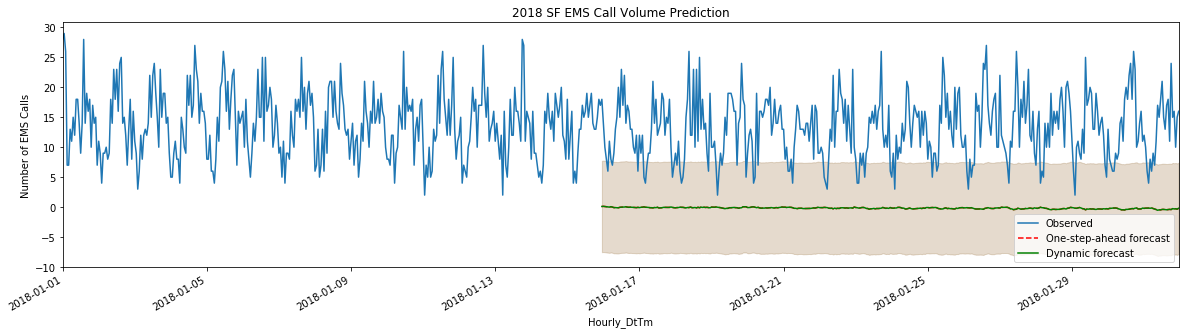

In [1008]:
#####  Graph
fig, ax = plt.subplots(figsize=(20,5))
npre = 4
ax.set(title='2018 SF EMS Call Volume Prediction', xlabel='Date', ylabel='Number of EMS Calls')

# Plot hourly_call_volume_medical_2018 points
plt.plot(hourly_call_volume_medical_2018.loc[:'2018-01-31 23:00:00'],label='Observed') #.plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2018-01-15 23:00:00':'2018-01-31 23:00:00'].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2018-01-15 23:00:00':'2018-01-31 23:00:00']
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['2018-01-15 23:00:00':'2018-01-31 23:00:00'].plot(ax=ax, style='g', label='Dynamic forecast')
ci = predict_dy_ci.loc['2018-01-15 23:00:00':'2018-01-31 23:00:00']
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

In [942]:
fit_res.params

ar.L1        0.020364
ar.L2        0.005808
ar.L3        0.012551
ma.L1       -0.989512
ar.S.L24     0.992042
ma.S.L24    -0.999975
sigma2      14.929759
dtype: float64

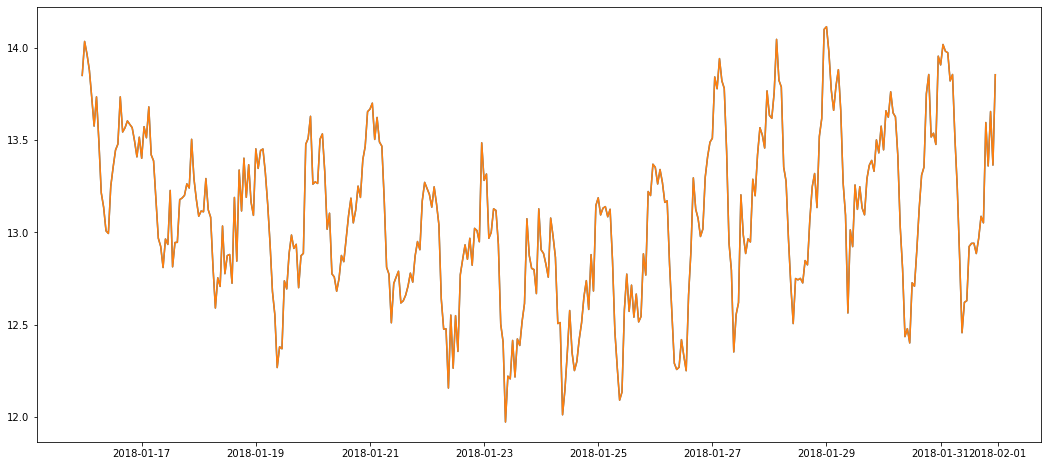

In [1004]:
sns.lineplot(data=predict.predicted_mean.loc['2018-01-15 23:00:00':'2018-01-31 23:00:00'])
sns.lineplot(data=predict_dy.predicted_mean.loc['2018-01-15 23:00:00':'2018-01-31 23:00:00'])

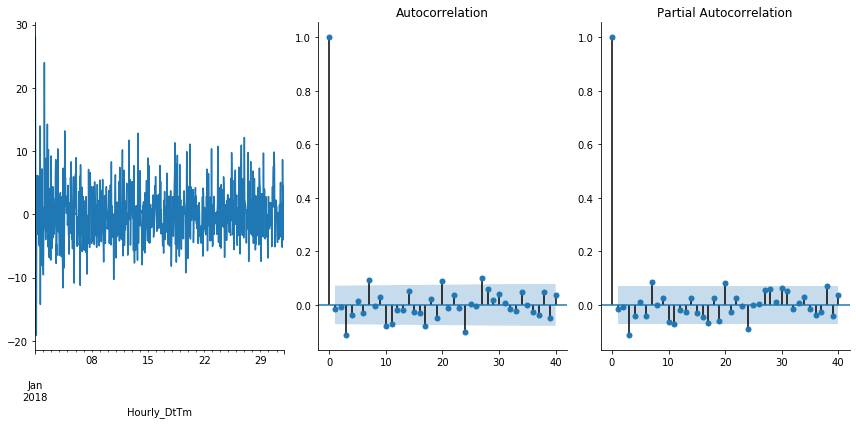

In [918]:
# plot resids
plots(pd.Series(fit_res.resid), lags=40);

In [885]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

In [ ]:
model